In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
# Read in datasets
df_em = pd.read_csv('Emissions by Country.csv')
df_gd = pd.read_csv('GDP by Country.csv')

In [3]:
# Get percent world emissions for 2017
df_em_2017 = df_em[['country_name', '2017']].rename(columns={'2017': 'emissions'}).set_index('country_name')

total_em_2017 = df_em_2017.at['GLOBAL TOTAL', 'emissions']
df_em_2017['percent_emissions'] = (df_em_2017['emissions'] / total_em_2017) * 100

df_em_2017 = df_em_2017.drop(['GLOBAL TOTAL'], axis=0)
del df_em_2017.index.name

In [4]:
# Get percent GDP for 2017
df_gd['2017'] = df_gd.drop(['2018'], axis=1).apply(lambda x:  x[x.last_valid_index()], axis=1)
df_gd = df_gd.drop(df_gd[df_gd['2017'].apply(type) == str].index)

cols = ['Country Name', '2017', 'Country Code']
df_gd_2017 = df_gd[cols].rename(columns={'2017': 'gdp', 'Country Code': 'code'}).set_index('Country Name')

total_gd_2017 = df_gd_2017.at['World', 'gdp']
df_gd_2017['percent_gdp'] = (df_gd_2017['gdp'] / total_gd_2017) * 100

df_gd_2017 = df_gd_2017.drop(['World'], axis=0)
del df_gd_2017.index.name

In [5]:
# Get codes for emissions data
rename = {'Bahamas, The': 'Bahamas', 'Brunei Darussalam': 'Brunei', 'Cabo Verde': 'Cape Verde', 'Congo':
          'Republic of the Congo', 'Congo, Rep.': 'Republic of the Congo', 'Côte d’Ivoire': "Cote d'Ivoire",
          'Curaçao': 'Curacao', 'Czech Republic': 'Czechia', 'Congo, Dem. Rep.': 'Democratic Republic of the Congo',
          'Egypt, Arab Rep.': 'Egypt', 'Faroes': 'Faroe Islands', 'former Yugoslav Republic of Macedonia, the':
          'North Macedonia', 'France and Monaco': 'France', 'Hong Kong SAR, China': 'Hong Kong', 'Lao PDR': 'Laos',
          'Iran, Islamic Rep.': 'Iran', 'Israel and Palestine, State of': 'Israel', 'Kyrgyz Republic': 'Kyrgyzstan',
          'Italy, San Marino and the Holy See': 'Italy', 'Macao SAR, China': 'Macao', 'Myanmar/Burma': 'Myanmar',
          'Korea, Dem. People’s Rep.': 'North Korea', 'Russian Federation': 'Russia', 'St. Kitts and Nevis':
          'Saint Kitts and Nevis', 'St. Lucia': 'Saint Lucia', 'São Tomé and Príncipe': 'Sao Tome and Principe',
          'St. Vincent and the Grenadines': 'Saint Vincent and the Grenadines', 'Serbia and Montenegro': 'Serbia',
          'Slovak Republic': 'Slovakia', 'Korea, Rep.': 'South Korea', 'Spain and Andorra': 'Spain', 'Swaziland':
          'Eswatini', 'Sudan and South Sudan': 'Sudan', 'Switzerland and Liechtenstein': 'Switzerland', 'Gambia, The':
          'The Gambia', 'Syrian Arab Republic': 'Syria', 'Venezuela, RB': 'Venezuela', 'Yemen, Rep.': 'Yemen'}
   
df_em_2017['country'] = df_em_2017.index.to_series().replace(rename)
df_gd_2017['country'] = df_gd_2017.index.to_series().replace(rename)

df_em_2017_codes = df_em_2017.merge(df_gd_2017[['country', 'code']], how='left', on='country')
df_em_2017_codes = df_em_2017_codes.dropna(subset=['code'])

In [6]:
# Recalculate select values for GDP data
df_gd_2017_adj = df_gd_2017.drop(['country'], axis=1)

df_gd_2017_adj.at['France', 'gdp'] = df_gd_2017.at['France', 'gdp'] + df_gd_2017.at['Monaco', 'gdp']
df_gd_2017_adj.at['Italy', 'gdp'] = df_gd_2017.at['Italy', 'gdp'] + df_gd_2017.at['San Marino', 'gdp']
df_gd_2017_adj.at['Serbia', 'gdp'] = df_gd_2017.at['Serbia', 'gdp'] + df_gd_2017.at['Montenegro', 'gdp']
df_gd_2017_adj.at['Spain', 'gdp'] = df_gd_2017.at['Spain', 'gdp'] + df_gd_2017.at['Andorra', 'gdp']
df_gd_2017_adj.at['Sudan', 'gdp'] = df_gd_2017.at['Sudan', 'gdp'] + df_gd_2017.at['South Sudan', 'gdp']
df_gd_2017_adj.at['Switzerland', 'gdp'] = df_gd_2017.at['Switzerland', 'gdp'] + df_gd_2017.at['Liechtenstein', 'gdp']

In [7]:
# Recalculate GDP percentages
df_gd_2017_adj['percent_gdp'] = (df_gd_2017_adj['gdp'] / total_gd_2017) * 100

In [8]:
# Merge percent world emissions and percent world GDP
df = df_em_2017_codes[['country', 'code', 'percent_emissions']].merge(df_gd_2017_adj[['code', 'percent_gdp']])

In [9]:
# Create new column for 'score' and 'rounded_score'
df['score'] = df['percent_emissions'] / df['percent_gdp']
df['rounded_score'] = round(df['score'].astype(float), 0)

In [10]:
# Export data
df.to_csv('Disproportionate Emisions by GDP.csv', index=False)

Text(0, 0.5, 'Ratio of Emissions Contributions to Share of World GDP')

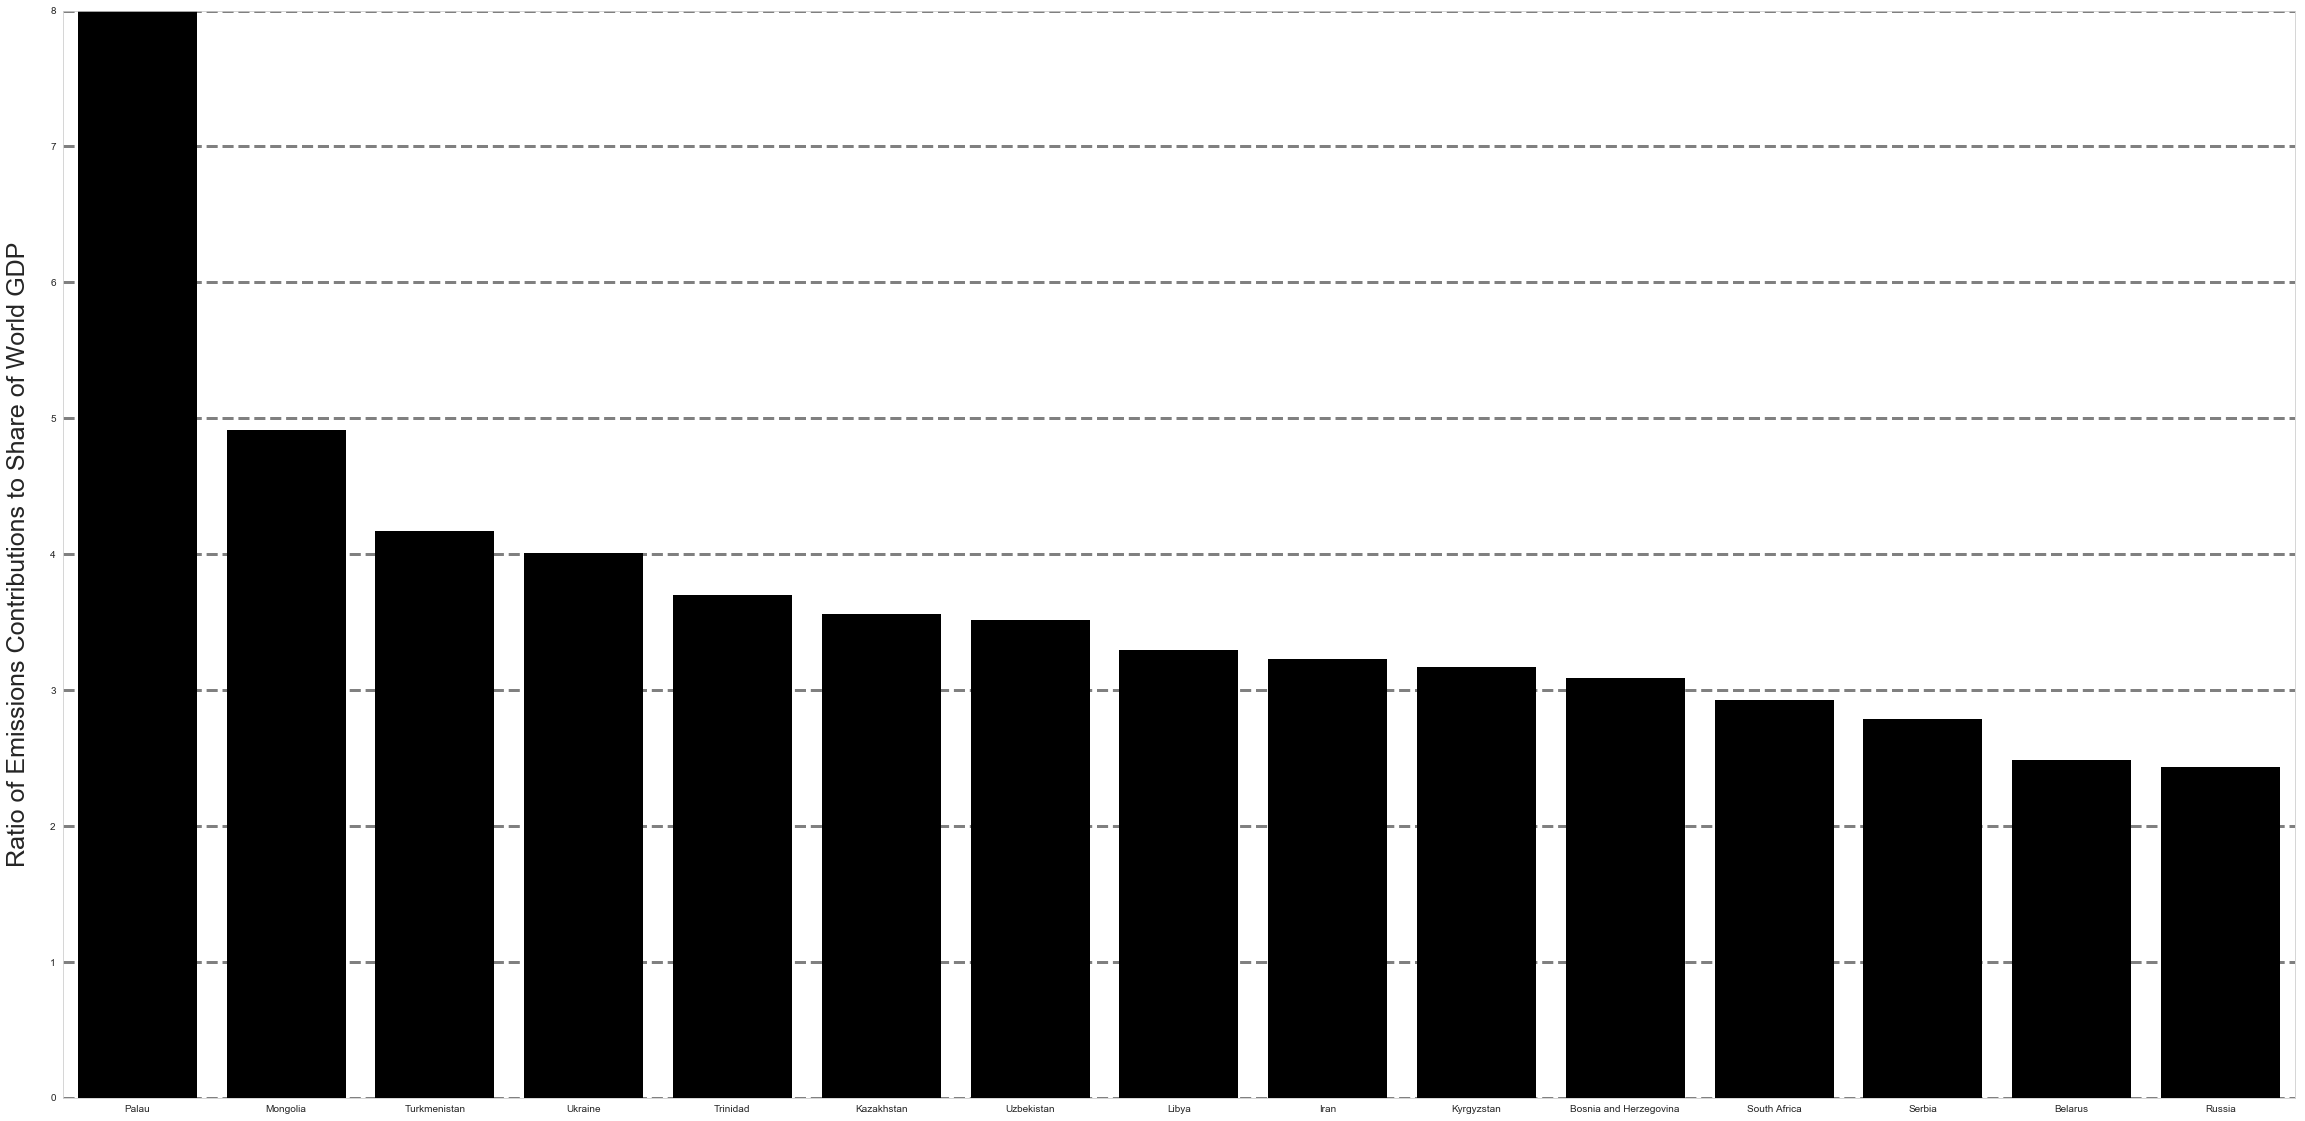

In [11]:
# Visualize top 10 worst
not_countries = ['Curacao', 'New Caledonia']
worst = df.sort_values(by='score', ascending=False).set_index('country').drop(not_countries).head(15).reset_index()
names = {'United Arab Emirates': 'UAE', 'Trinidad and Tobago': 'Trinidad', 'United States': 'USA'}
worst['country'] = worst['country'].replace(names)
plt.figure(figsize=(40, 20))
plt.tight_layout()
color = ['black']

plt.grid(color='gray', linestyle='--', linewidth=3)

plot = sns.barplot(x='country', y='score', data=worst, palette=color)
plt.ylim(0,8)
plt.setp(plot.patches, linewidth=0)

sns.set(style='darkgrid', font='monospace')
sns.set_context("notebook", font_scale=4, rc={"lines.linewidth": 5})
plt.xlabel('')
plt.ylabel('Ratio of Emissions Contributions to Share of World GDP', fontsize=25, labelpad=20)

In [12]:
df

,country,code,percent_emissions,percent_gdp,score,rounded_score
0,Afghanistan,AFG,0.030801,0.0249589,1.23406,1.0
1,Albania,ALB,0.013566,0.0161002,0.842621,1.0
2,Algeria,DZA,0.431346,0.207664,2.07713,2.0
3,Angola,AGO,0.083286,0.150803,0.552283,1.0
4,Antigua and Barbuda,ATG,0.001672,0.00186661,0.895848,1.0
5,Argentina,ARG,0.566308,0.794808,0.712509,1.0
6,Armenia,ARM,0.013027,0.014249,0.914234,1.0
7,Aruba,ABW,0.002589,0.00333814,0.775642,1.0
8,Australia,AUS,1.084904,1.644,0.659916,1.0
9,Austria,AUT,0.194865,0.515451,0.378047,0.0
